In [2]:
# Load data
print("Loading data...")
adata = sc.read_h5ad('data/adata_processed.h5ad')
with open('outputs/p1/split_structured.json', 'r') as f:
    split = json.load(f)

forget_idx = np.array(split['forget_indices'])
retain_idx = np.array(split['retain_indices'])
test_idx = np.array(split.get('test_indices', []))

print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Test: {len(test_idx)}")

Loading data...


Forget: 30, Retain: 28094, Test: 0


In [ ]:
# Theory Analyses
import numpy as np
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
import sys
sys.path.append('src')
from vae import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [3]:
# Load models
print("Loading models...")
baseline_checkpoint = torch.load('outputs/p1/baseline_v2/best_model.pt', map_location=device)
config = baseline_checkpoint['config']

def load_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    has_batchnorm = any('running_mean' in k or 'running_var' in k for k in state_dict.keys())
    use_layer_norm = not has_batchnorm
    
    model = VAE(
        input_dim=config['input_dim'],
        hidden_dims=config['hidden_dims'],
        latent_dim=config['latent_dim'],
        likelihood=config.get('likelihood', 'nb'),
        use_layer_norm=use_layer_norm
    ).to(device)
    
    model.load_state_dict(state_dict)
    model.eval()
    return model

baseline_model = load_model('outputs/p1/baseline_v2/best_model.pt')
fisher_model = load_model('outputs/p2/fisher_unlearn_structured/unlearned_model.pt')
retrain_model = load_model('outputs/p1/retrain_structured_v2/best_model.pt')

print("Models loaded successfully")

Loading models...


Models loaded successfully


## 1. ELBO Decomposition (F/R Splits)

In [ ]:
# ELBO Decomposition
def compute_elbo_components(model, adata, indices):
    """Compute ELBO = -recon_loss - KL for a data split."""
    model.eval()
    total_recon = 0.0
    total_kl = 0.0
    n_samples = 0
    
    with torch.no_grad():
        for i in range(0, len(indices), 256):
            batch_idx = indices[i:i+256]
            x = torch.FloatTensor(
                adata.X[batch_idx].toarray() if hasattr(adata.X, 'toarray') else adata.X[batch_idx]
            ).to(device)
            
            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            recon = model.decode(z)
            
            # NB log-likelihood
            if isinstance(recon, tuple):
                mu_dec, theta = recon
                eps = 1e-10
                log_theta_mu_eps = torch.log(theta + mu_dec + eps)
                log_nb = (
                    theta * (torch.log(theta + eps) - log_theta_mu_eps)
                    + x * (torch.log(mu_dec + eps) - log_theta_mu_eps)
                    + torch.lgamma(x + theta) - torch.lgamma(theta) - torch.lgamma(x + 1)
                )
                recon_loss = -log_nb.sum(dim=1)
            else:
                recon_loss = ((x - recon) ** 2).sum(dim=1)
            
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
            
            total_recon += recon_loss.sum().item()
            total_kl += kl_div.sum().item()
            n_samples += len(batch_idx)
    
    mean_recon = total_recon / n_samples
    mean_kl = total_kl / n_samples
    elbo = -(mean_recon + mean_kl)
    return elbo, mean_recon, mean_kl

# Compute ELBO decomposition
print("Computing ELBO decomposition...")
elbo_data = {}

for model_name, model in [('baseline', baseline_model), ('fisher', fisher_model), ('retrain', retrain_model)]:
    elbo_data[model_name] = {}
    for split_name, indices in [('forget', forget_idx), ('retain', retain_idx)]:
        if len(indices) == 0:
            continue
        elbo, recon, kl = compute_elbo_components(model, adata, indices)
        elbo_data[model_name][split_name] = {'elbo': elbo, 'recon': recon, 'kl': kl}
        print(f"  {model_name}/{split_name}: ELBO={elbo:.2f}, Recon={recon:.2f}, KL={kl:.2f}")

In [ ]:
# Visualize ELBO decomposition
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['baseline', 'fisher', 'retrain']
x_pos = np.arange(len(models))
width = 0.35

# Panel 1: ELBO
ax = axes[0]
forget_elbo = [elbo_data[m]['forget']['elbo'] for m in models]
retain_elbo = [elbo_data[m]['retain']['elbo'] for m in models]
ax.bar(x_pos - width/2, forget_elbo, width, label='Forget', alpha=0.8)
ax.bar(x_pos + width/2, retain_elbo, width, label='Retain', alpha=0.8)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('ELBO', fontsize=12)
ax.set_title('ELBO by Model and Split', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Panel 2: Reconstruction Loss
ax = axes[1]
forget_recon = [elbo_data[m]['forget']['recon'] for m in models]
retain_recon = [elbo_data[m]['retain']['recon'] for m in models]
ax.bar(x_pos - width/2, forget_recon, width, label='Forget', alpha=0.8)
ax.bar(x_pos + width/2, retain_recon, width, label='Retain', alpha=0.8)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Reconstruction Loss', fontsize=12)
ax.set_title('Reconstruction Loss', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Panel 3: KL Divergence
ax = axes[2]
forget_kl = [elbo_data[m]['forget']['kl'] for m in models]
retain_kl = [elbo_data[m]['retain']['kl'] for m in models]
ax.bar(x_pos - width/2, forget_kl, width, label='Forget', alpha=0.8)
ax.bar(x_pos + width/2, retain_kl, width, label='Retain', alpha=0.8)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('KL Divergence', fontsize=12)
ax.set_title('KL Divergence', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/p2/theory_elbo_decomp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/theory_elbo_decomp.png")

# Save results
elbo_results = {'analysis': 'elbo_decomposition', 'description': 'ELBO decomposition (recon + KL) for F/R splits', 'models': {}}
for model_name in models:
    elbo_results['models'][model_name] = {}
    for split_name in ['forget', 'retain']:
        elbo_results['models'][model_name][split_name] = {
            'elbo': float(elbo_data[model_name][split_name]['elbo']),
            'recon': float(elbo_data[model_name][split_name]['recon']),
            'kl': float(elbo_data[model_name][split_name]['kl'])
        }

with open('outputs/p2/theory_elbo_decomp.json', 'w') as f:
    json.dump(elbo_results, f, indent=2)

print("Saved: outputs/p2/theory_elbo_decomp.json")

## 2. Per-Dimension KL and Var[z] Analysis

In [4]:
def compute_per_dim_kl_var(model, adata, indices, batch_size=256):
    """Compute per-dimension KL divergence and variance of latent codes."""
    model.eval()
    all_mu = []
    all_logvar = []
    
    with torch.no_grad():
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = torch.FloatTensor(
                adata.X[batch_indices].toarray() if hasattr(adata.X, 'toarray') 
                else adata.X[batch_indices]
            ).to(device)
            
            mu, logvar = model.encode(x_batch)
            all_mu.append(mu.cpu().numpy())
            all_logvar.append(logvar.cpu().numpy())
    
    mu = np.vstack(all_mu)
    logvar = np.vstack(all_logvar)
    
    # Per-dimension KL divergence: KL(q(z_i|x) || p(z_i))
    # KL = 0.5 * (mu^2 + exp(logvar) - logvar - 1)
    per_dim_kl = 0.5 * (mu**2 + np.exp(logvar) - logvar - 1)
    mean_kl_per_dim = per_dim_kl.mean(axis=0)
    
    # Per-dimension variance of latent codes
    var_z_per_dim = mu.var(axis=0)
    
    return mean_kl_per_dim, var_z_per_dim, mu, logvar

In [5]:
# Compute for all models on all splits
print("Computing per-dimension statistics...")
results = {}

for model_name, model in [('baseline', baseline_model), ('fisher', fisher_model), ('retrain', retrain_model)]:
    results[model_name] = {}
    
    for split_name, indices in [('forget', forget_idx), ('retain', retain_idx)]:
        if len(indices) == 0:
            continue
        
        kl, var_z, mu, logvar = compute_per_dim_kl_var(model, adata, indices)
        results[model_name][split_name] = {
            'per_dim_kl': kl,
            'var_z_per_dim': var_z,
            'mu': mu,
            'logvar': logvar
        }
        print(f"  {model_name}/{split_name}: KL={kl.mean():.4f}, Var[z]={var_z.mean():.4f}")

Computing per-dimension statistics...
  baseline/forget: KL=0.5530, Var[z]=0.0278


  baseline/retain: KL=0.3366, Var[z]=0.2824
  fisher/forget: KL=0.0001, Var[z]=0.0000


  fisher/retain: KL=0.0001, Var[z]=0.0001
  retrain/forget: KL=0.3972, Var[z]=0.0398


  retrain/retain: KL=0.3120, Var[z]=0.2061


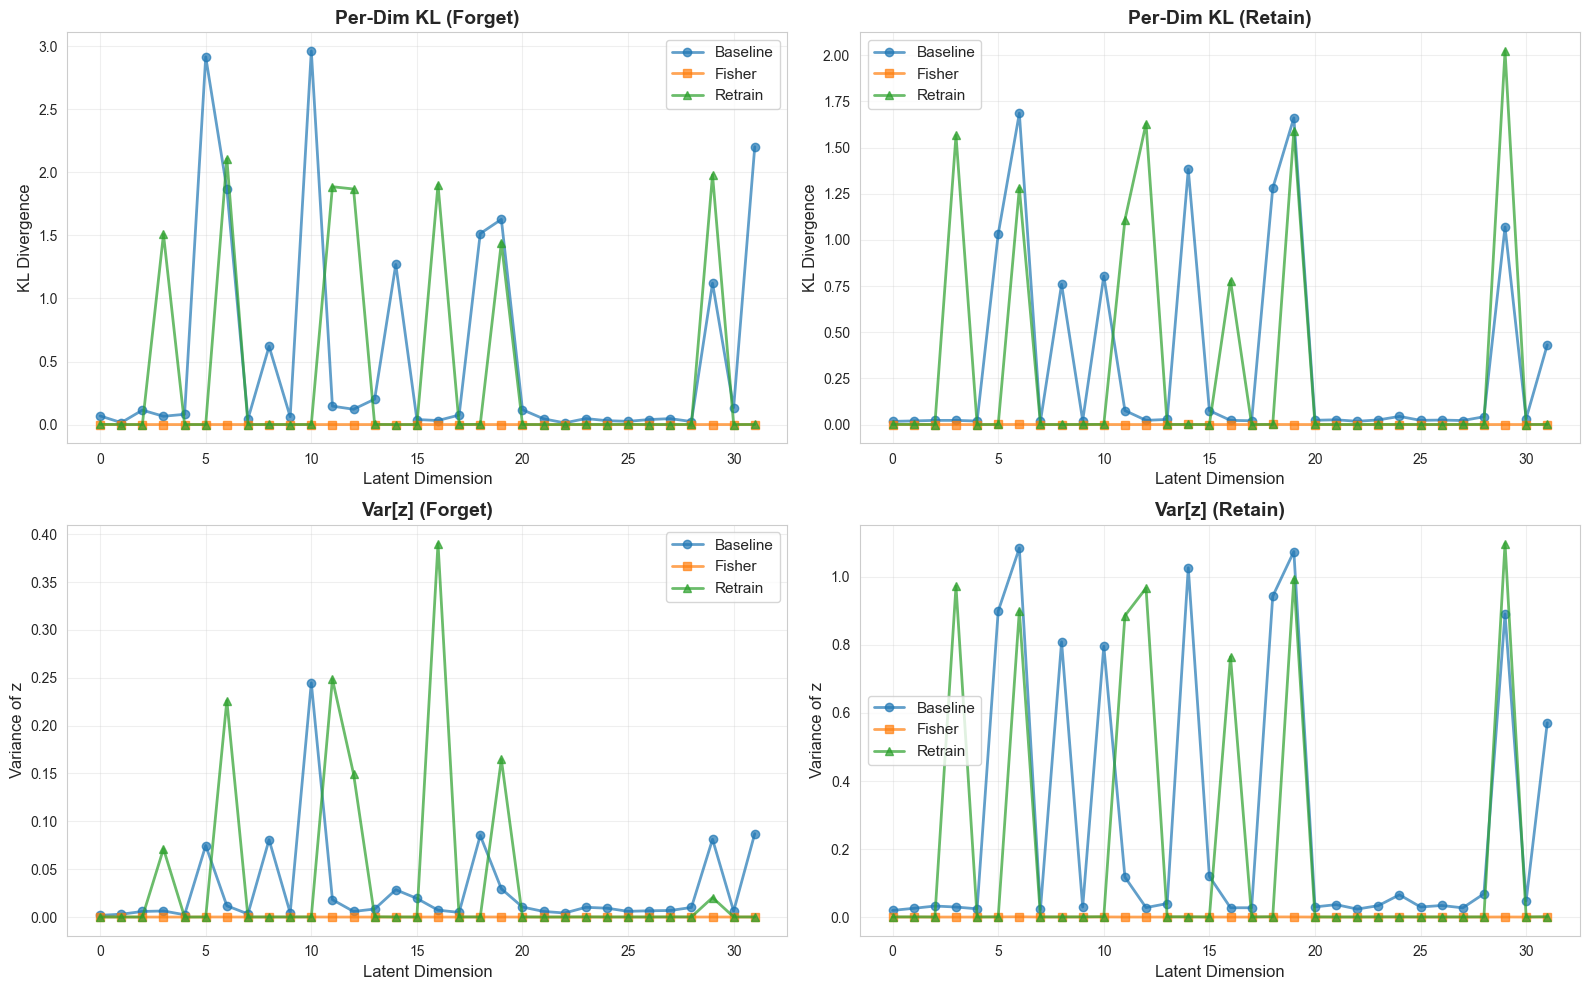

Saved: outputs/p2/theory_per_dim_kl_var.png


In [6]:
# Visualize per-dimension KL and Var[z]
latent_dim = config['latent_dim']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Row 1: Per-dimension KL for forget and retain
for i, split_name in enumerate(['forget', 'retain']):
    ax = axes[0, i]
    
    baseline_kl = results['baseline'][split_name]['per_dim_kl']
    fisher_kl = results['fisher'][split_name]['per_dim_kl']
    retrain_kl = results['retrain'][split_name]['per_dim_kl']
    
    x = np.arange(latent_dim)
    ax.plot(x, baseline_kl, 'o-', label='Baseline', alpha=0.7, linewidth=2)
    ax.plot(x, fisher_kl, 's-', label='Fisher', alpha=0.7, linewidth=2)
    ax.plot(x, retrain_kl, '^-', label='Retrain', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Latent Dimension', fontsize=12)
    ax.set_ylabel('KL Divergence', fontsize=12)
    ax.set_title(f'Per-Dim KL ({split_name.capitalize()})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

# Row 2: Per-dimension Var[z] for forget and retain
for i, split_name in enumerate(['forget', 'retain']):
    ax = axes[1, i]
    
    baseline_var = results['baseline'][split_name]['var_z_per_dim']
    fisher_var = results['fisher'][split_name]['var_z_per_dim']
    retrain_var = results['retrain'][split_name]['var_z_per_dim']
    
    x = np.arange(latent_dim)
    ax.plot(x, baseline_var, 'o-', label='Baseline', alpha=0.7, linewidth=2)
    ax.plot(x, fisher_var, 's-', label='Fisher', alpha=0.7, linewidth=2)
    ax.plot(x, retrain_var, '^-', label='Retrain', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Latent Dimension', fontsize=12)
    ax.set_ylabel('Variance of z', fontsize=12)
    ax.set_title(f'Var[z] ({split_name.capitalize()})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/theory_per_dim_kl_var.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/theory_per_dim_kl_var.png")

In [ ]:
# Save results
per_dim_results = {
    'analysis': 'per_dim_kl_var',
    'description': 'Per-dimension KL divergence and Var[z] analysis',
    'latent_dim': int(latent_dim),
    'models': {}
}

for model_name in ['baseline', 'fisher', 'retrain']:
    per_dim_results['models'][model_name] = {}
    for split_name in ['forget', 'retain']:
        per_dim_results['models'][model_name][split_name] = {
            'mean_kl': float(results[model_name][split_name]['per_dim_kl'].mean()),
            'mean_var_z': float(results[model_name][split_name]['var_z_per_dim'].mean()),
            'per_dim_kl': results[model_name][split_name]['per_dim_kl'].tolist(),
            'var_z_per_dim': results[model_name][split_name]['var_z_per_dim'].tolist()
        }

with open('outputs/p2/theory_per_dim_kl_var.json', 'w') as f:
    json.dump(per_dim_results, f, indent=2)

print("Saved: outputs/p2/theory_per_dim_kl_var.json")

## 3. Decoder Test (Reconstruction vs Prior)

In [8]:
def decoder_test(model, adata, indices, n_prior_samples=100):
    """Compare reconstruction from encoder vs sampling from prior."""
    model.eval()
    
    # Get a sample of forget data
    sample_size = min(len(indices), 100)
    sample_indices = np.random.choice(indices, sample_size, replace=False)
    
    x = torch.FloatTensor(
        adata.X[sample_indices].toarray() if hasattr(adata.X, 'toarray') 
        else adata.X[sample_indices]
    ).to(device)
    
    with torch.no_grad():
        # Reconstruction: encode then decode
        mu, logvar = model.encode(x)
        z_encoded = model.reparameterize(mu, logvar)
        recon_from_encoder = model.decode(z_encoded)
        
        # Prior: sample from N(0, I) then decode
        latent_dim = mu.shape[1]
        prior_nlls = []
        
        for _ in range(n_prior_samples):
            z_prior = torch.randn(sample_size, latent_dim).to(device)
            recon_from_prior = model.decode(z_prior)
            
            # Compute NLL for NB likelihood
            if isinstance(recon_from_prior, tuple):
                mu_dec, theta = recon_from_prior
                
                # NB NLL
                eps = 1e-10
                log_theta_mu_eps = torch.log(theta + mu_dec + eps)
                nll = (
                    theta * (torch.log(theta + eps) - log_theta_mu_eps)
                    + x * (torch.log(mu_dec + eps) - log_theta_mu_eps)
                    + torch.lgamma(x + theta)
                    - torch.lgamma(theta)
                    - torch.lgamma(x + 1)
                )
                nll = -nll.sum(dim=1)
            else:
                # Gaussian NLL
                recon_loss = ((x - recon_from_prior) ** 2).sum(dim=1)
                nll = recon_loss
            
            prior_nlls.append(nll.cpu().numpy())
        
        # Compute NLL for reconstruction from encoder
        if isinstance(recon_from_encoder, tuple):
            mu_dec, theta = recon_from_encoder
            eps = 1e-10
            log_theta_mu_eps = torch.log(theta + mu_dec + eps)
            nll_encoder = (
                theta * (torch.log(theta + eps) - log_theta_mu_eps)
                + x * (torch.log(mu_dec + eps) - log_theta_mu_eps)
                + torch.lgamma(x + theta)
                - torch.lgamma(theta)
                - torch.lgamma(x + 1)
            )
            nll_encoder = -nll_encoder.sum(dim=1).cpu().numpy()
        else:
            recon_loss = ((x - recon_from_encoder) ** 2).sum(dim=1)
            nll_encoder = recon_loss.cpu().numpy()
    
    prior_nlls = np.array(prior_nlls)  # shape: (n_prior_samples, sample_size)
    mean_nll_prior = prior_nlls.mean(axis=0)
    std_nll_prior = prior_nlls.std(axis=0)
    
    return nll_encoder, mean_nll_prior, std_nll_prior

In [9]:
print("Running decoder test on forget set...")
decoder_results = {}

for model_name, model in [('baseline', baseline_model), ('fisher', fisher_model), ('retrain', retrain_model)]:
    nll_enc, nll_prior_mean, nll_prior_std = decoder_test(model, adata, forget_idx, n_prior_samples=100)
    decoder_results[model_name] = {
        'nll_encoder': nll_enc,
        'nll_prior_mean': nll_prior_mean,
        'nll_prior_std': nll_prior_std
    }
    print(f"  {model_name}: NLL(encoder)={nll_enc.mean():.2f}, NLL(prior)={nll_prior_mean.mean():.2f}")

Running decoder test on forget set...


  baseline: NLL(encoder)=2790.24, NLL(prior)=2922.36


  fisher: NLL(encoder)=2863.27, NLL(prior)=2863.94


  retrain: NLL(encoder)=2839.15, NLL(prior)=2927.56


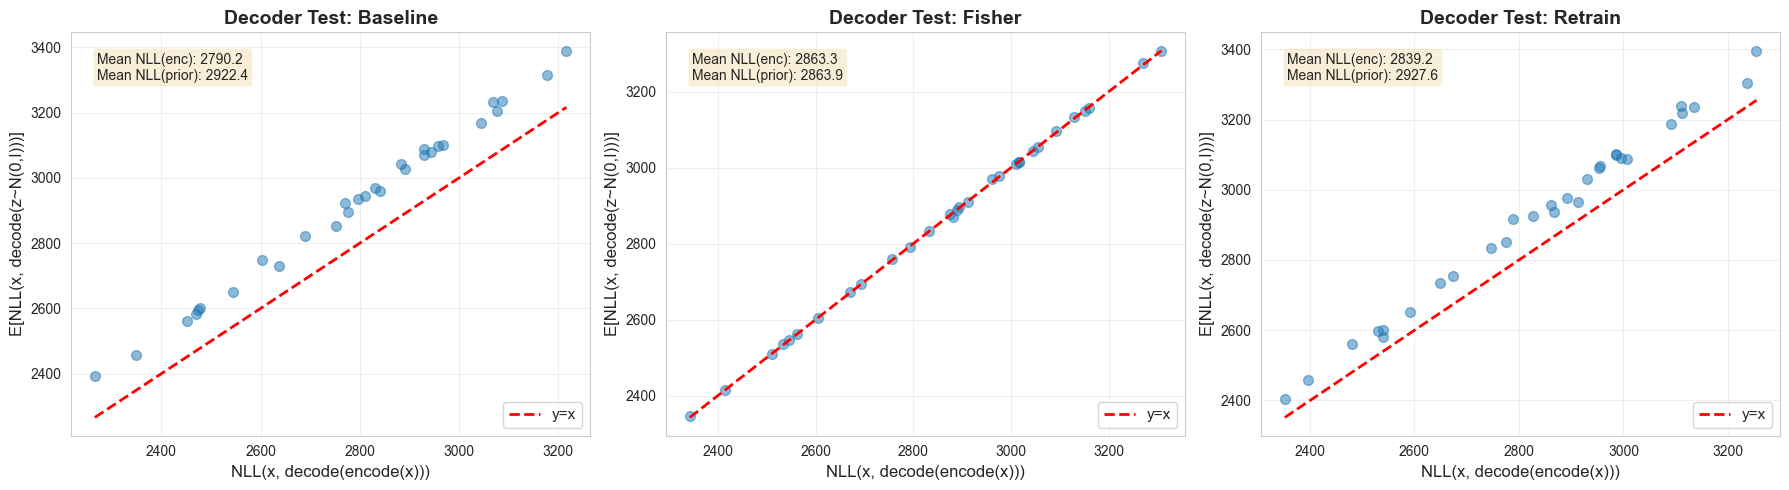

Saved: outputs/p2/theory_decoder_test.png


In [10]:
# Visualize decoder test
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, ax) in enumerate(zip(['baseline', 'fisher', 'retrain'], axes)):
    nll_enc = decoder_results[model_name]['nll_encoder']
    nll_prior = decoder_results[model_name]['nll_prior_mean']
    
    # Scatter plot
    ax.scatter(nll_enc, nll_prior, alpha=0.5, s=50)
    ax.plot([nll_enc.min(), nll_enc.max()], [nll_enc.min(), nll_enc.max()],
            'r--', label='y=x', linewidth=2)
    
    ax.set_xlabel('NLL(x, decode(encode(x)))', fontsize=12)
    ax.set_ylabel('E[NLL(x, decode(z~N(0,I)))]', fontsize=12)
    ax.set_title(f'Decoder Test: {model_name.capitalize()}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    # Add text with mean values
    ax.text(0.05, 0.95, f'Mean NLL(enc): {nll_enc.mean():.1f}\nMean NLL(prior): {nll_prior.mean():.1f}',
            transform=ax.transAxes, va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('outputs/p2/theory_decoder_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/theory_decoder_test.png")

In [ ]:
# Save results
decoder_test_results = {
    'analysis': 'decoder_test',
    'description': 'Decoder test: reconstruction vs prior sampling',
    'n_prior_samples': 100,
    'models': {}
}

for model_name in ['baseline', 'fisher', 'retrain']:
    decoder_test_results['models'][model_name] = {
        'mean_nll_encoder': float(decoder_results[model_name]['nll_encoder'].mean()),
        'mean_nll_prior': float(decoder_results[model_name]['nll_prior_mean'].mean()),
        'ratio': float(decoder_results[model_name]['nll_encoder'].mean() / decoder_results[model_name]['nll_prior_mean'].mean())
    }

with open('outputs/p2/theory_decoder_test.json', 'w') as f:
    json.dump(decoder_test_results, f, indent=2)

print("Saved: outputs/p2/theory_decoder_test.json")

## 4. Posterior Shift Visualization (PCA)

In [12]:
# Use the mu values we already computed
print("Running PCA on latent means...")

# Get forget and retain set latent codes
all_mu_baseline_forget = results['baseline']['forget']['mu']
all_mu_fisher_forget = results['fisher']['forget']['mu']
all_mu_retrain_forget = results['retrain']['forget']['mu']

# Subsample retain set for clarity
all_mu_baseline_retain = results['baseline']['retain']['mu'][:500]
all_mu_fisher_retain = results['fisher']['retain']['mu'][:500]
all_mu_retrain_retain = results['retrain']['retain']['mu'][:500]

# Fit PCA on baseline retain set (reference space)
pca = PCA(n_components=2)
pca.fit(all_mu_baseline_retain)

# Transform all data
baseline_forget_pca = pca.transform(all_mu_baseline_forget)
fisher_forget_pca = pca.transform(all_mu_fisher_forget)
retrain_forget_pca = pca.transform(all_mu_retrain_forget)

baseline_retain_pca = pca.transform(all_mu_baseline_retain)
fisher_retain_pca = pca.transform(all_mu_fisher_retain)
retrain_retain_pca = pca.transform(all_mu_retrain_retain)

# Prior samples
prior_samples = np.random.randn(500, latent_dim)
prior_pca = pca.transform(prior_samples)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")

Running PCA on latent means...
PCA explained variance: [0.13863666 0.1296467 ]


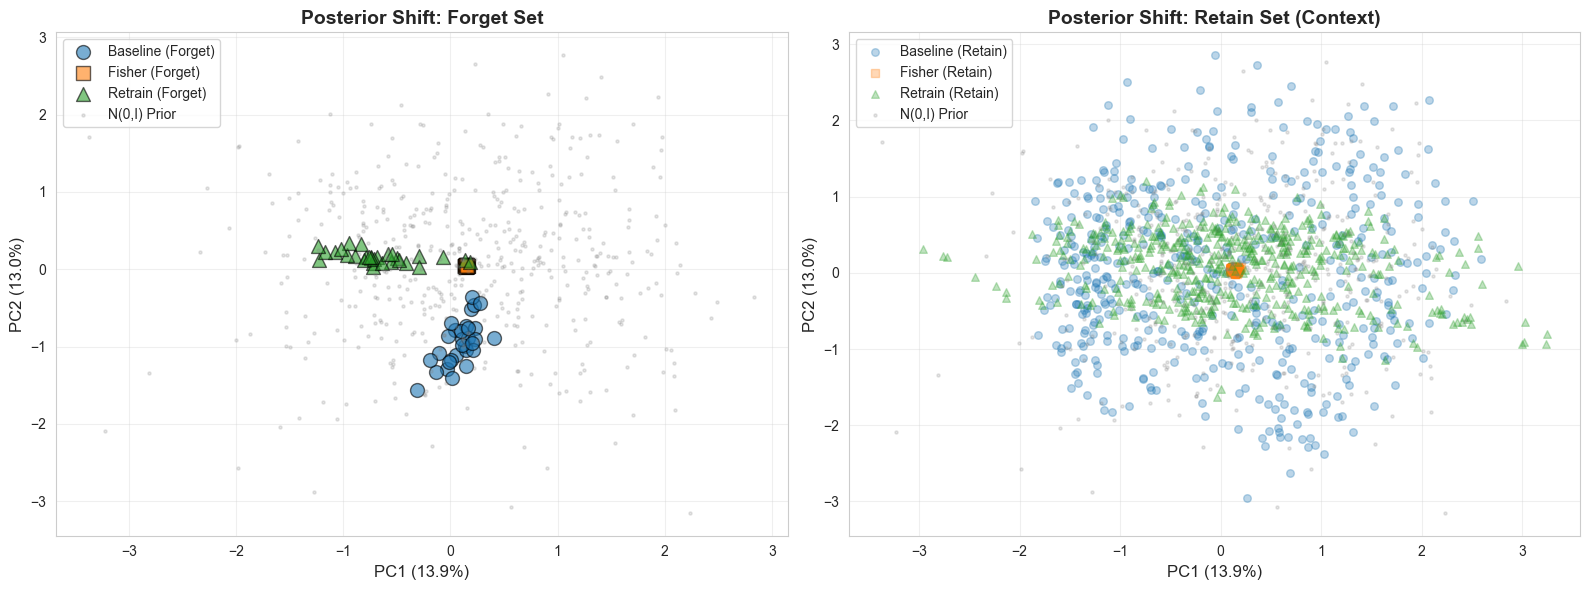

Saved: outputs/p2/theory_posterior_shift.png


In [13]:
# Visualize posterior shift
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Forget set across models
ax = axes[0]
ax.scatter(baseline_forget_pca[:, 0], baseline_forget_pca[:, 1],
           alpha=0.6, s=100, label='Baseline (Forget)', marker='o', edgecolor='black')
ax.scatter(fisher_forget_pca[:, 0], fisher_forget_pca[:, 1],
           alpha=0.6, s=100, label='Fisher (Forget)', marker='s', edgecolor='black')
ax.scatter(retrain_forget_pca[:, 0], retrain_forget_pca[:, 1],
           alpha=0.6, s=100, label='Retrain (Forget)', marker='^', edgecolor='black')
ax.scatter(prior_pca[:, 0], prior_pca[:, 1],
           alpha=0.2, s=20, label='N(0,I) Prior', marker='.', color='gray')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title('Posterior Shift: Forget Set', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Panel 2: Retain set across models (context)
ax = axes[1]
ax.scatter(baseline_retain_pca[:, 0], baseline_retain_pca[:, 1],
           alpha=0.3, s=30, label='Baseline (Retain)', marker='o')
ax.scatter(fisher_retain_pca[:, 0], fisher_retain_pca[:, 1],
           alpha=0.3, s=30, label='Fisher (Retain)', marker='s')
ax.scatter(retrain_retain_pca[:, 0], retrain_retain_pca[:, 1],
           alpha=0.3, s=30, label='Retrain (Retain)', marker='^')
ax.scatter(prior_pca[:, 0], prior_pca[:, 1],
           alpha=0.2, s=20, label='N(0,I) Prior', marker='.', color='gray')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title('Posterior Shift: Retain Set (Context)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/theory_posterior_shift.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/theory_posterior_shift.png")

In [ ]:
# Save PCA results
posterior_shift_results = {
    'analysis': 'posterior_shift',
    'description': 'Posterior shift visualization via PCA on latent means',
    'pca_explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
    'forget_set': {
        'baseline_mean_pc1': float(baseline_forget_pca[:, 0].mean()),
        'baseline_mean_pc2': float(baseline_forget_pca[:, 1].mean()),
        'fisher_mean_pc1': float(fisher_forget_pca[:, 0].mean()),
        'fisher_mean_pc2': float(fisher_forget_pca[:, 1].mean()),
        'retrain_mean_pc1': float(retrain_forget_pca[:, 0].mean()),
        'retrain_mean_pc2': float(retrain_forget_pca[:, 1].mean())
    }
}

with open('outputs/p2/theory_posterior_shift.json', 'w') as f:
    json.dump(posterior_shift_results, f, indent=2)

print("Saved: outputs/p2/theory_posterior_shift.json")

## Summary

Theory analyses complete!

**Outputs generated:**
- `outputs/p2/theory_per_dim_kl_var.{png,json}`
- `outputs/p2/theory_decoder_test.{png,json}`
- `outputs/p2/theory_posterior_shift.{png,json}`